TINN Parameter Estimation for Drift Diffusion Model
Generating synthetic DDM data...
Generated 1756 upper and 244 lower boundary crossings
Starting TINN training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'tinn_identification_net_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


It 00000: loss = 2.56171379e+01 drift = 1.30596101e+00 sigma = 9.90000308e-01 t0 = 2.97139406e-01
It 00050: loss = 3.14851046e+00 drift = 1.19017553e+00 sigma = 7.92547345e-01 t0 = 3.08924496e-01
It 00100: loss = 6.21100068e-01 drift = 8.96496773e-01 sigma = 4.94431525e-01 t0 = 3.05270731e-01
It 00150: loss = 3.22460592e-01 drift = 7.37954140e-01 sigma = 4.42337960e-01 t0 = 3.03024024e-01
It 00200: loss = 2.35490188e-01 drift = 6.65584385e-01 sigma = 4.19739544e-01 t0 = 3.00771594e-01
It 00250: loss = 2.00664788e-01 drift = 6.20833457e-01 sigma = 4.08890784e-01 t0 = 2.97879428e-01
It 00300: loss = 1.82629406e-01 drift = 5.85103512e-01 sigma = 4.05344695e-01 t0 = 2.94309705e-01
It 00350: loss = 1.70075938e-01 drift = 5.52616298e-01 sigma = 4.05949056e-01 t0 = 2.90171713e-01
It 00400: loss = 1.59287348e-01 drift = 5.21368563e-01 sigma = 4.08749104e-01 t0 = 2.85573274e-01
It 00450: loss = 1.49134979e-01 drift = 4.90682364e-01 sigma = 4.12361085e-01 t0 = 2.80600399e-01
It 00500: loss = 1.3

/tmp/ipython-input-1226247179.py:338: RuntimeWarning: divide by zero encountered in scalar divide
  return (a/np.sqrt(2*np.pi*t**3)*np.exp(-(v*t-a)**2/(2*t)))
/tmp/ipython-input-1226247179.py:338: RuntimeWarning: invalid value encountered in scalar multiply
  return (a/np.sqrt(2*np.pi*t**3)*np.exp(-(v*t-a)**2/(2*t)))


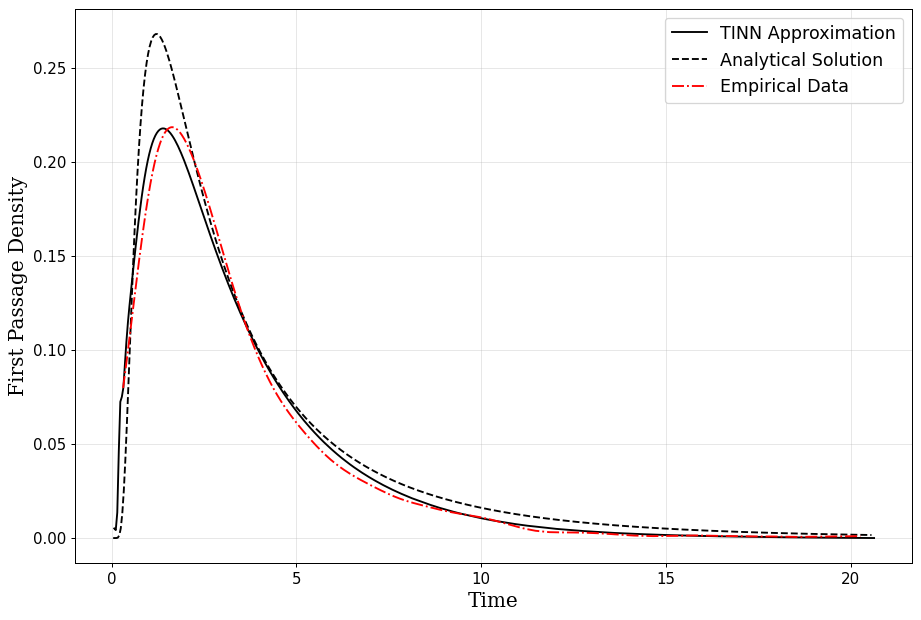


Analysis completed successfully!


In [4]:
"""
Theoretical-Informed Neural Network (TINN) for Parameter Estimation in DDM model

"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.optimize import minimize

# =============================================================================
# Configuration
# =============================================================================

# Simulation parameters
NUM_SIMULATIONS = 2000
TIME_STEPS = 20000
DT = 0.01
NON_DECISION_TIME = 0.3

# True parameters for DDM
DRIFT_RATE = 0.5
BOUNDARY_SEPARATION = 2.0
STARTING_POINT = 0.0
NOISE_STD = 1.0

# TINN training parameters
NUM_EPOCHS = 50000
NUM_HIDDEN_LAYERS = 4
NUM_NEURONS_PER_LAYER = 30
THRESHOLD = 2.0

# =============================================================================
# DDM Simulation
# =============================================================================

def simulate_ddm_rk4(num_simulations, time_steps, drift_rate, boundary_separation, starting_point, noise_std, dt):
    decision_times1 = []
    decision_times2 = []
    noise = np.random.normal(0, noise_std, (num_simulations, time_steps))

    for i in range(num_simulations):
        decision_variable = starting_point
        for t in range(time_steps):
            k1 = drift_rate * dt + noise[i, t] * np.sqrt(dt)
            k2 = drift_rate * dt + noise[i, t] * np.sqrt(dt)
            k3 = drift_rate * dt + noise[i, t] * np.sqrt(dt)
            k4 = drift_rate * dt + noise[i, t] * np.sqrt(dt)
            decision_variable += (k1 + 2*k2 + 2*k3 + k4) / 6

            if decision_variable >= boundary_separation:
                decision_times1.append(t * dt)
                break
            elif decision_variable <= -boundary_separation:
                decision_times2.append(t * dt)
                break
    return np.array(decision_times1), np.array(decision_times2)

# =============================================================================
# TINN Architecture
# =============================================================================

class TINN_NeuralNet(tf.keras.Model):
    def __init__(self, lb, ub, output_dim=1, num_hidden_layers=5, num_neurons_per_layer=50, activation='tanh', kernel_initializer='glorot_normal', **kwargs):
        super().__init__(**kwargs)
        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get(activation), kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers-1)]
        self.hidden1 = tf.keras.layers.Dense(num_neurons_per_layer, activation='softplus')
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        Z = X
        for i in range(self.num_hidden_layers-1):
            Z = self.hidden[i](Z)
        return self.out(Z)

class TINNIdentificationNet(TINN_NeuralNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambd = self.add_weight(name="lambd_raw", initializer="ones", trainable=True, dtype=tf.float32)
        self.sig = self.add_weight(name="sig", initializer="ones", trainable=True, dtype=tf.float32)
        self.tt0 = self.add_weight(name="tt0", initializer="ones", trainable=True, dtype=tf.float32)
        self.lambd_list = []
        self.sig_list = []
        self.tt0_list = []

# =============================================================================
# TINN Solver
# =============================================================================

class TINNSolver():
    def __init__(self, model, X_r):
        self.model = model
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]
        self.hist = []
        self.iter = 0

    def get_r(self):
        with tf.GradientTape(persistent=False) as tape:
            tape.watch(self.t)
            tape.watch(self.x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            u_x = tape.gradient(u, self.x)
        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        del tape
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)

    def loss_fn(self, X, xmax, rt1, rt2, u):
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))
        loss_r = phi_r

        u_pred = self.model(X[0])
        loss_0 = tf.reduce_mean(tf.square(u[0] - u_pred))

        u_pred = self.model(X[1])
        loss_b = tf.reduce_mean(tf.square(u[1] - u_pred))

        tspace1 = np.sort(rt1)
        tspace2 = np.sort(rt2)
        tspace_tf1 = tf.constant(tspace1.reshape((len(rt1),1)), 'float32')
        minRT1 = min(rt1)
        minRT2 = min(rt2)
        self.minRT = min(minRT1, minRT2)
        t1 = tspace_tf1 - tf.math.sigmoid(self.model.tt0)*self.minRT

        xspace = np.ones((len(tspace1),1))*xmax
        xtf = tf.constant(xspace, 'float32')
        X_bound = tf.concat([t1, xtf], 1)
        p_i = self.model(X_bound)

        xspace1 = np.ones((len(tspace1),1))*(xmax-0.02)
        xtf1 = tf.constant(xspace1, 'float32')
        X1 = tf.concat([t1, xtf1], 1)
        p_ii = self.model(X1)

        xspace2 = np.ones((len(tspace1),1))*(xmax-0.04)
        xtf2 = tf.constant(xspace2, 'float32')
        X2 = tf.concat([t1, xtf2], 1)
        p_iii = self.model(X2)
        p_x = (3*p_i - 4*p_ii + p_iii)/(2*0.02)

        J1 = tf.nn.softplus(self.model.lambd)* p_i - 0.5*(self.model.sig)**2*p_x
        kde1 = gaussian_kde(tspace1)
        p_kde1 = len(tspace1)*kde1(tspace1)[:, np.newaxis]/(len(tspace2)+len(tspace1))
        p_kde_tensor1 = tf.convert_to_tensor(p_kde1, dtype=tf.float32)
        KDE_loss1 = tf.reduce_mean(tf.square(J1 - p_kde_tensor1))

        tspace_tf2 = tf.constant(tspace2.reshape((len(rt2),1)), 'float32')
        t2 = tspace_tf2 - tf.math.sigmoid(self.model.tt0)*self.minRT

        xspace20 = np.ones((len(tspace2),1))*(-xmax)
        xtf20 = tf.constant(xspace20, 'float32')
        X20 = tf.concat([t2, xtf20], 1)
        p_i2 = self.model(X20)

        xspace21 = np.ones((len(tspace2),1))*(-xmax+0.02)
        xtf21 = tf.constant(xspace21, 'float32')
        X21 = tf.concat([t2, xtf21], 1)
        p_ii2 = self.model(X21)

        xspace22 = np.ones((len(tspace2),1))*(-xmax+0.04)
        xtf22 = tf.constant(xspace22, 'float32')
        X22 = tf.concat([t2, xtf22], 1)
        p_iii2 = self.model(X22)
        p_x2 = (-3*p_i2 + 4*p_ii2 - p_iii2)/(2*0.02)

        J2 = tf.nn.softplus(self.model.lambd)* p_i2 - 0.5*(self.model.sig)**2*p_x2
        kde2 = gaussian_kde(tspace2)
        p_kde2 = -len(tspace2)*kde2(tspace2)[:, np.newaxis]/(len(tspace2)+len(tspace1))
        p_kde_tensor2 = tf.convert_to_tensor(p_kde2, dtype=tf.float32)
        KDE_loss2 = tf.reduce_mean(tf.square(J2 - p_kde_tensor2))

        return 100*(loss_r + loss_0 + loss_b) + KDE_loss1 + KDE_loss2

    def get_grad(self, X, xmax, rt1, rt2, u):
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, xmax, rt1, rt2, u)
        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        return loss, g

    def solve_with_TFoptimizer(self, optimizer, X, xmax, rt1, rt2, u, N=1001):
        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, xmax, rt1, rt2, u)
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):
            loss = train_step()
            self.current_loss = loss.numpy()
            self.callback()

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter += 1

# =============================================================================
# Fokker-Planck TINN Solver
# =============================================================================

class F_P_TINNSolver(TINNSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_r(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.t)
            tape.watch(self.x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))
            u_x = tape.gradient(u, self.x)
        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        del tape
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)

class F_P_TINNIdentification(F_P_TINNSolver):
    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        return u_t + tf.nn.softplus(self.model.lambd)*u_x - 0.5*(self.model.sig)**2*u_xx

    def callback(self, xr=None):
        mu = tf.nn.softplus(self.model.lambd)
        sigma = self.model.sig
        lambd = mu.numpy()
        sig = sigma.numpy()
        tt0 = (tf.math.sigmoid(self.model.tt0)*self.minRT).numpy()
        self.model.lambd_list.append(lambd)
        self.model.sig_list.append(sig)
        self.model.tt0_list.append(tt0)
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e} drift = {:10.8e} sigma = {:10.8e} t0 = {:10.8e}'.format(self.iter, self.current_loss, lambd, sig, tt0-0.15))
        self.hist.append(self.current_loss)
        self.iter += 1

    def lambdaf(self):
        mu = tf.nn.softplus(self.model.lambd)
        return mu.numpy()

    def sigmaf(self):
        return self.model.sig.numpy()

    def tt0f(self):
        return (tf.math.sigmoid(self.model.tt0)*self.minRT).numpy()

# =============================================================================
# Main Execution
# =============================================================================

def main():
    print("TINN Parameter Estimation for Drift Diffusion Model")
    print("=" * 50)

    # Generate synthetic data
    print("Generating synthetic DDM data...")
    decision_times1, decision_times2 = simulate_ddm_rk4(NUM_SIMULATIONS, TIME_STEPS, DRIFT_RATE, BOUNDARY_SEPARATION, STARTING_POINT, NOISE_STD, DT)
    rt1 = np.sort(decision_times1) + NON_DECISION_TIME
    rt2 = np.sort(decision_times2) + NON_DECISION_TIME
    print(f"Generated {len(rt1)} upper and {len(rt2)} lower boundary crossings")

    # Prepare domain and training data
    xmax = THRESHOLD
    xmin = -xmax
    maxrt1 = max(rt1)
    maxrt2 = max(rt2)
    lb = tf.constant([0, xmin], dtype='float32')
    ub = tf.constant([max(maxrt1, maxrt2), xmax], dtype='float32')

    # Collocation points
    N = 100
    tspace = np.linspace(lb[0], ub[0], N + 1)
    xspace = np.linspace(lb[1], ub[1], N + 1)
    T, X = np.meshgrid(tspace, xspace)
    Xgrid = np.vstack([T.flatten(), X.flatten()]).T
    Xgrid = tf.constant(Xgrid, 'float32')

    # Boundary conditions
    def ddf(x, delta, x0):
        return 1/(2*np.sqrt(np.pi*delta))*tf.math.exp(-((x-x0)**2)/(4*delta))

    def fun_u_0(x):
        return ddf(x, 7.8e-2, 0)

    N_b = 500
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype='float32')
    x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype='float32')
    X_b = tf.concat([t_b, x_b], axis=1)
    u_b = tf.zeros(tf.shape(x_b), 'float32')

    N_0 = 50
    t_0 = tf.ones((N_0,1), dtype='float32')*lb[0]
    x_0 = np.linspace(lb[1], ub[1], N_0-1, dtype='float32')
    x_0 = np.asarray(list(x_0) + [0.0])
    x_0 = np.sort(x_0)
    x_0 = tf.convert_to_tensor(x_0, dtype='float32')
    x_0 = tf.reshape(x_0, [N_0,1])
    u_0 = fun_u_0(x_0)
    X_0 = tf.concat([t_0, x_0], axis=1)

    X_param = [X_0, X_b]
    u_param = [u_0, u_b]

    # Initialize and train TINN
    model = TINNIdentificationNet(lb, ub, num_hidden_layers=NUM_HIDDEN_LAYERS, num_neurons_per_layer=NUM_NEURONS_PER_LAYER, activation='tanh', kernel_initializer='glorot_normal')

    f_p_Identification = F_P_TINNIdentification(model, Xgrid)

    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,15000], [0.01,0.001,0.0005])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)

    print("Starting TINN training...")
    t0 = time()
    f_p_Identification.solve_with_TFoptimizer(optim, X_param, xmax, rt1, rt2, u_param, N=NUM_EPOCHS)
    print('\nComputation time: {} seconds'.format(time()-t0))

    # Results
    print("\nTrue parameters: Drift = {:.4f}, Noise = {:.4f}, Non-decision = {:.4f}".format(DRIFT_RATE, NOISE_STD, NON_DECISION_TIME))
    print("Estimated parameters: Drift = {:.4f}, Noise = {:.4f}, Non-decision = {:.4f}".format(f_p_Identification.lambdaf(), f_p_Identification.sigmaf(), f_p_Identification.tt0f()-0.15))

    # Visualization
    plot_results(model, f_p_Identification, rt1, rt2, lb, ub, DRIFT_RATE, BOUNDARY_SEPARATION)

def plot_results(model, solver, rt1, rt2, lb, ub, drift_rate, boundary_separation):
    # Analytical solution
    def f(v, a, t):
        return (a/np.sqrt(2*np.pi*t**3)*np.exp(-(v*t-a)**2/(2*t)))

    # Upper boundary
    M = 500
    tspace = np.linspace(0, ub[0], M + 1)
    xspace = np.ones((M+1))*ub[1]
    X = np.zeros((M+1,2))
    X[:,0] = tspace
    X[:,1] = xspace
    X = tf.constant(X, 'float32')
    p_i = model(X)

    xspace1 = np.ones((M+1))*(ub[1]-0.02)
    X1 = np.zeros((M+1,2))
    X1[:,0] = tspace
    X1[:,1] = xspace1
    X1 = tf.constant(X1, 'float32')
    p_ii = model(X1)

    xspace2 = np.ones((M+1))*(ub[1]-0.04)
    X2 = np.zeros((M+1,2))
    X2[:,0] = tspace
    X2[:,1] = xspace2
    X2 = tf.constant(X2, 'float32')
    p_iii = model(X2)
    p_x = (3*p_i - 4*p_ii + p_iii)/(2*0.02)
    J1 = solver.lambdaf()* p_i - 0.5*solver.sigmaf()**2*p_x

    F1 = [f(drift_rate, boundary_separation, rt) for rt in np.sort(tspace)]
    kde1 = gaussian_kde(rt1)

    font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 16}

    plt.figure(figsize=(12, 8), dpi=90)
    plt.plot(tspace + 0.07, J1, label='TINN Approximation', color='black')
    plt.plot(tspace, np.asarray(F1), label='Analytical Solution', color='black', linestyle='--')
    plt.plot(rt1 - 0.3, len(rt1)*kde1(rt1)[:, np.newaxis]/(len(rt1)+len(rt2)), label='Empirical Data', color='red', linestyle='-.')
    plt.xlabel('Time', fontdict=font)
    plt.ylabel('First Passage Density', fontdict=font)
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(True, alpha=0.3)
    plt.savefig("tinn_upper_boundary.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    print("\nAnalysis completed successfully!")

if __name__ == "__main__":
    main()